In [1]:
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation

metadata_path = "./data/PBMC/PBMC_68k/hg19/68k_pbmc_barcodes_annotation.tsv"
true_labels = evaluation.load_true_labels(metadata_path, "barcodes", "celltype", "\t")
print(true_labels.info())
print(true_labels.head())

def load_expression_data_from_mtx(path, matrix_name, genes_name, barcodes_name, barcodes_labeled=None, n_sample=None, random_state=None):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+matrix_name).tocsc()
    print("Matrix read")

    # Load genes
    genes = pd.read_csv(path+genes_name, header=None, sep='\t', names=['gene_id', 'gene_symbol'])
    print("Genes read")

    # Load barcodes
    barcodes = pd.read_csv(path+barcodes_name, header=None, sep='\t', names=['barcode'])
    print("Barcodes read")

    # Filter by labeled barcodes if barcodes_labeled is provided
    if barcodes_labeled is not None:
        if 'barcode' not in barcodes_labeled.columns:
            raise ValueError("The provided barcodes_labeled DataFrame must contain a 'barcode' column.")
        # Find the intersection of barcodes
        labeled_barcodes = set(barcodes_labeled['barcode'])
        matching_indices = barcodes['barcode'].isin(labeled_barcodes)
        matrix = matrix[:, matching_indices]
        barcodes = barcodes[matching_indices]

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix

expression_matrix = load_expression_data_from_mtx("./data/PBMC/PBMC_68k/hg19/",
                                                  matrix_name = "matrix.mtx", genes_name = "genes.tsv", barcodes_name = "barcodes.tsv",
                                                  barcodes_labeled=true_labels, n_sample=None, random_state=6)

print(expression_matrix.info())

c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68579 entries, 0 to 68578
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   barcode     68579 non-null  object
 1   true_label  68579 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB
None
            barcode                    true_label
0  AAACATACACCCAA-1              CD8+ Cytotoxic T
1  AAACATACCCCTCA-1  CD8+/CD45RA+ Naive Cytotoxic
2  AAACATACCGGAGA-1           CD4+/CD45RO+ Memory
3  AAACATACTAACCG-1                       CD19+ B
4  AAACATACTCTTCA-1               CD4+/CD25 T Reg
Matrix read
Genes read
Barcodes read
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Columns: 68579 entries, AAACATACACCCAA-1 to TTTGCATGTGGTAC-8
dtypes: Sparse[float64, 0](68579)
memory usage: 427.4+ MB
None


In [2]:
duplicated_genes = expression_matrix.index[expression_matrix.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")

print(true_labels['true_label'].unique())

['CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'CD4+/CD45RO+ Memory'
 'CD19+ B' 'CD4+/CD25 T Reg' 'CD56+ NK' 'CD4+ T Helper2'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+' 'Dendritic' 'CD14+ Monocyte']


In [9]:
# duplicados en metadata tumor
duplicated_cells = true_labels.index[true_labels.index.duplicated()]
if len(duplicated_cells) > 0:
    print(f"celulas duplicadas encontradas: {duplicated_genes}")

In [3]:
from importlib import reload
reload(data_cleaning)
import gc
gc.collect()
print("\tMatrix 1")
cleaned_matrix1 = data_cleaning.filter_lowly_expressed_genes(expression_matrix)
print(cleaned_matrix1.info())
"""
print("\tMatrix 2")
cleaned_matrix2 = data_cleaning.filter_high_mitochondrial_content(expression_matrix)
print(cleaned_matrix2.info())

print("\tMatrix 3")
cleaned_matrix3 = data_cleaning.filter_doublets_cxds(expression_matrix)
print(cleaned_matrix3.info())
"""
#print("\tMatrix Combined")
#cleaned_matrix_combined = data_cleaning.combined_cleaning(expression_matrix)
#print(cleaned_matrix_combined.info())


	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 17768 entries, AL627309.1 to ZNF84
Columns: 68579 entries, AAACATACACCCAA-1 to TTTGCATGTGGTAC-8
dtypes: Sparse[float64, 0](68579)
memory usage: 427.2+ MB
None


'\nprint("\tMatrix 2")\ncleaned_matrix2 = data_cleaning.filter_high_mitochondrial_content(expression_matrix)\nprint(cleaned_matrix2.info())\n\nprint("\tMatrix 3")\ncleaned_matrix3 = data_cleaning.filter_doublets_cxds(expression_matrix)\nprint(cleaned_matrix3.info())\n'

In [4]:
reload(normalization)
import gc
gc.collect()
print("\tMatrix 1")
norm_matrix1 = normalization.normalize_cpm(cleaned_matrix1)
print(norm_matrix1.info())
"""
gc.collect()
import time
start_time = time.time()
print("\tMatrix 2")
norm_matrix2 = normalization.normalize_quantile_regression(cleaned_matrix1)
end_time = time.time()
print(norm_matrix2.info())
execution_time = end_time - start_time  
print(f"Tiempo de ejecución: {execution_time} segundos")

start_time = time.time()
print("\tMatrix 3")
norm_matrix3 = normalization.normalize_negative_binomial(cleaned_matrix1)
end_time = time.time()
print(norm_matrix3.info())
execution_time = end_time - start_time  
print(f"Tiempo de ejecución: {execution_time} segundos")
"""

	Matrix 1
Non-zero elements before normalization: 37319717
Non-zero elements after normalization: 37319717
<class 'pandas.core.frame.DataFrame'>
Index: 17768 entries, AL627309.1 to ZNF84
Columns: 68579 entries, AAACATACACCCAA-1 to TTTGCATGTGGTAC-8
dtypes: Sparse[float64, 0](68579)
memory usage: 427.2+ MB
None


'\ngc.collect()\nimport time\nstart_time = time.time()\nprint("\tMatrix 2")\nnorm_matrix2 = normalization.normalize_quantile_regression(cleaned_matrix1)\nend_time = time.time()\nprint(norm_matrix2.info())\nexecution_time = end_time - start_time  \nprint(f"Tiempo de ejecución: {execution_time} segundos")\n\nstart_time = time.time()\nprint("\tMatrix 3")\nnorm_matrix3 = normalization.normalize_negative_binomial(cleaned_matrix1)\nend_time = time.time()\nprint(norm_matrix3.info())\nexecution_time = end_time - start_time  \nprint(f"Tiempo de ejecución: {execution_time} segundos")\n'

In [5]:
# Feature selection
reload(feature_selection)
gc.collect()
print("\tMatrix 1")
selected_matrix1 = feature_selection.select_highly_variable_genes(norm_matrix1)
print(selected_matrix1.info())

print("\tMatrix 2")
selected_matrix2 = feature_selection.select_genes_by_variance(norm_matrix1)
print(selected_matrix2.info())

	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, PPBP to RP11-307E17.8
Columns: 68579 entries, AAACATACACCCAA-1 to TTTGCATGTGGTAC-8
dtypes: Sparse[float64, 0](68579)
memory usage: 82.9+ MB
None
	Matrix 2
<class 'pandas.core.frame.DataFrame'>
Index: 1777 entries, ISG15 to UQCR11
Columns: 68579 entries, AAACATACACCCAA-1 to TTTGCATGTGGTAC-8
dtypes: Sparse[float64, 0](68579)
memory usage: 304.4+ MB
None


In [8]:
# Dim reduction
reload(dim_reduction)
gc.collect()
print("\tPCA")
pca_object, pca_matrix = dim_reduction.apply_pca(selected_matrix1, threshold = 4000)
print(pca_matrix.info())
print(pca_object)
print(pca_matrix.shape[1])

print("\tUMAP")
umap_matrix = dim_reduction.apply_umap(selected_matrix1, pca_matrix.shape[1])
print(umap_matrix.info())

print("\tt-SNE")
tsne_matrix = dim_reduction.apply_tsne(selected_matrix1, 2)
print(tsne_matrix.info())

	PCA
<class 'pandas.core.frame.DataFrame'>
Index: 68579 entries, AAACATACACCCAA-1 to TTTGCATGTGGTAC-8
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC_1    68579 non-null  float64
 1   PC_2    68579 non-null  float64
 2   PC_3    68579 non-null  float64
 3   PC_4    68579 non-null  float64
 4   PC_5    68579 non-null  float64
 5   PC_6    68579 non-null  float64
 6   PC_7    68579 non-null  float64
 7   PC_8    68579 non-null  float64
 8   PC_9    68579 non-null  float64
dtypes: float64(9)
memory usage: 7.2+ MB
None
PCA(n_components=50)
9
	UMAP
<class 'pandas.core.frame.DataFrame'>
Index: 68579 entries, AAACATACACCCAA-1 to TTTGCATGTGGTAC-8
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UMAP_1  68579 non-null  float32
 1   UMAP_2  68579 non-null  float32
 2   UMAP_3  68579 non-null  float32
 3   UMAP_4  68579 non-null  float32
 4   UMAP_5  68579 non-null  floa

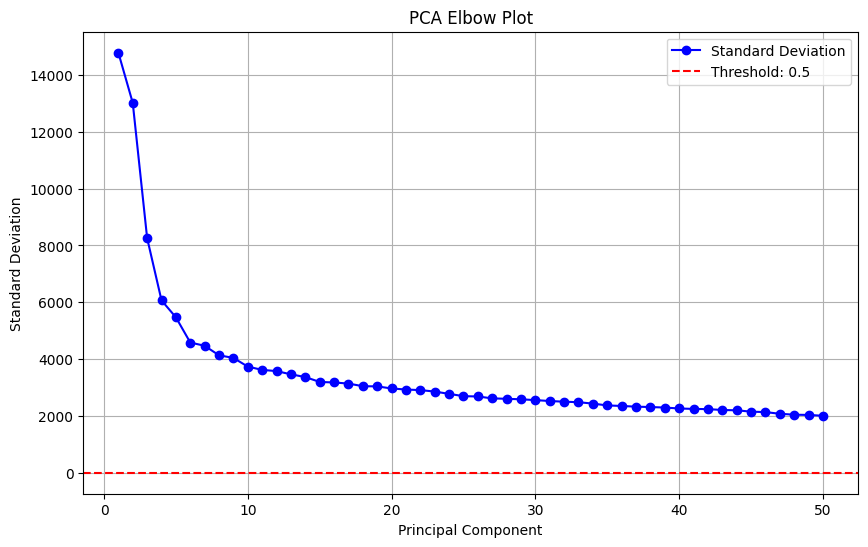

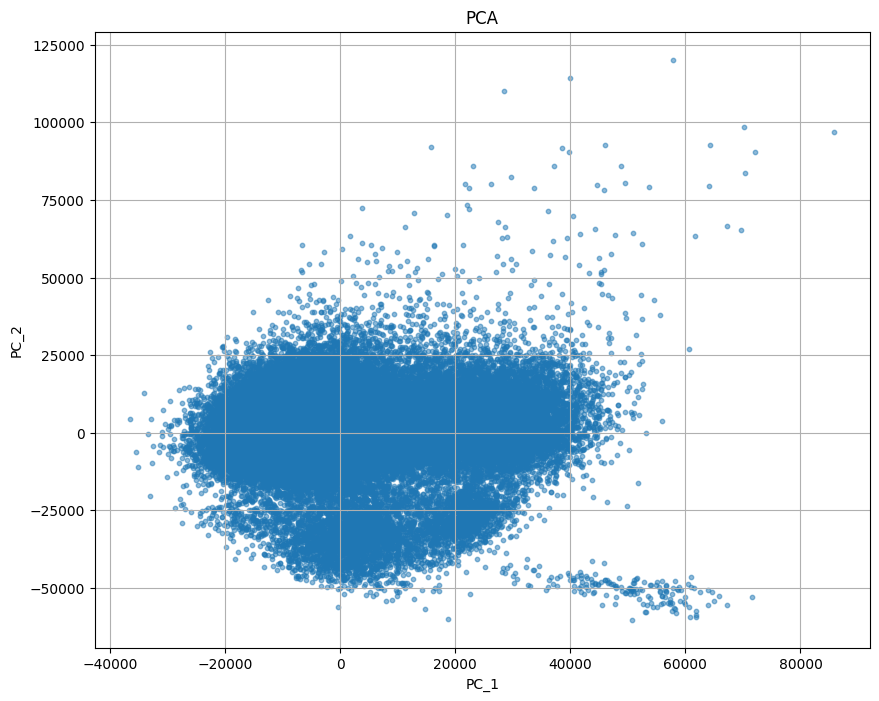

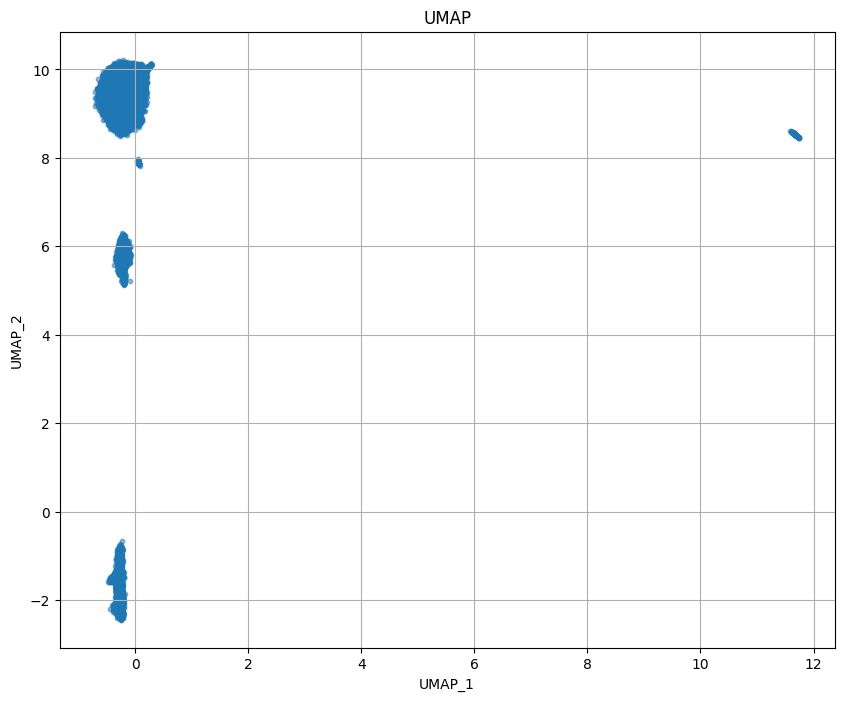

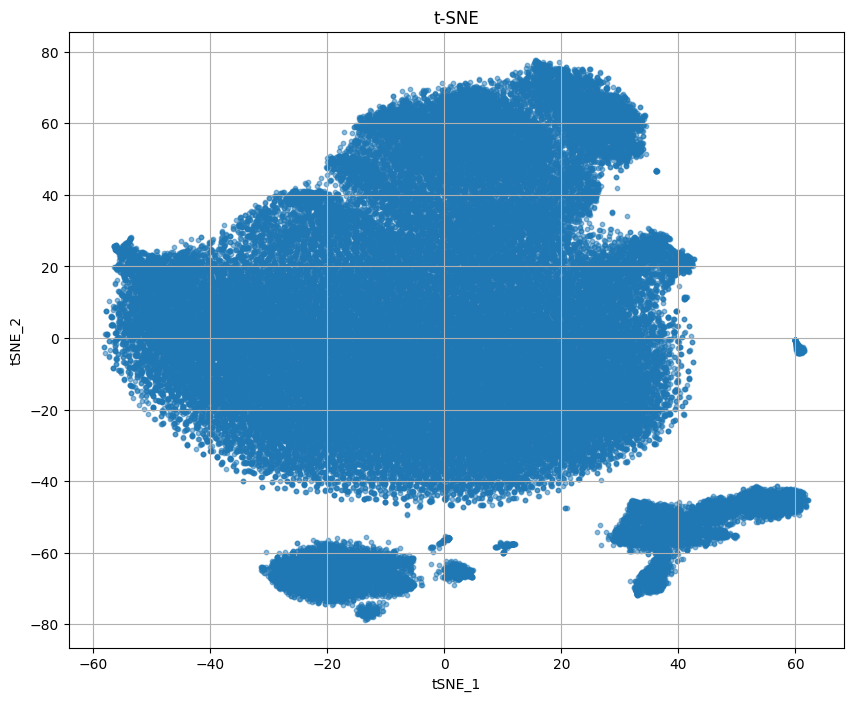

In [9]:
# Visualization
reload(dim_reduction)
# elbow plot
dim_reduction.elbow_plot(pca_object)
# visualization
dim_reduction.visualize_dim_reduction(pca_matrix.iloc[:, :2], 'PCA')
dim_reduction.visualize_dim_reduction(umap_matrix.iloc[:, :2], 'UMAP')
dim_reduction.visualize_dim_reduction(tsne_matrix.iloc[:, :2], 't-SNE')


In [10]:
# Clustering
reload(clustering)
gc.collect()
print("\tGraph based")
clustering1, gbl_results = clustering.graph_based_clustering_leiden(umap_matrix, n_clusters=11)
print(clustering1.head())
print(clustering1.unique())
print(gbl_results)

	Graph based
5
0.1
10
0.1
15
0.1
barcode
AAACATACACCCAA-1    1
AAACATACCCCTCA-1    1
AAACATACCGGAGA-1    1
AAACATACTAACCG-1    5
AAACATACTCTTCA-1    0
dtype: int32
[ 1  5  0  3  2  7  6  4  8  9 10]
{'n_neighbors': 15, 'resolution': 0.1, 'num_clusters': 11}


In [202]:
reload(clustering)
gc.collect()
print("\tDensity based")
clustering2, db_params = clustering.density_based_clustering(pca_matrix, n_clusters=11)
print(clustering2.head())
print(clustering2.unique())
print(db_params)

	Density based
3.0
3



KeyboardInterrupt



In [205]:
reload(clustering)
gc.collect()
print("\tDistance based")
clustering3 = clustering.distance_based_clustering(pca_matrix, n_clusters=11)
print(clustering3.head())
print(clustering3.unique())

	Distance based
barcode
AAACATACACCCAA-1    1
AAACATACCCCTCA-1    3
AAACATACCGGAGA-1    3
AAACATACTAACCG-1    7
AAACATACTCTTCA-1    1
dtype: int32
[ 1  3  7  9  8 10  2  5  4  0  6]


In [228]:
reload(clustering)
gc.collect()
print("\tHierarchical")
clustering4 = clustering.hierarchical_clustering(umap_matrix, n_clusters=11)
print(clustering4.head())
print(clustering4.unique())

	Hierarchical
barcode
AAACATACACCCAA-1    2.0
AAACATACCCCTCA-1    2.0
AAACATACCGGAGA-1    2.0
AAACATACTAACCG-1    7.0
AAACATACTCTTCA-1    1.0
dtype: float64
[ 2.  7.  1.  3.  8.  4. 10.  5.  9.  0.  6.]


In [221]:
reload(clustering)
print("\tDeep Learning")
clustering5 = clustering.deep_learning_clustering(umap_matrix, n_clusters=11)
print(clustering5.head())
print(clustering5.unique())

	Deep Learning
Epoch 1/50
268/268 [==============================] - 1s 2ms/step - loss: 309.1319
Epoch 2/50
268/268 [==============================] - 0s 2ms/step - loss: 2.4160
Epoch 3/50
268/268 [==============================] - 0s 2ms/step - loss: 0.8252
Epoch 4/50
268/268 [==============================] - 0s 2ms/step - loss: 0.5554
Epoch 5/50
268/268 [==============================] - 0s 2ms/step - loss: 0.3888
Epoch 6/50
268/268 [==============================] - 0s 2ms/step - loss: 0.2821
Epoch 7/50
268/268 [==============================] - 0s 2ms/step - loss: 0.2132
Epoch 8/50
268/268 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 9/50
268/268 [==============================] - 0s 2ms/step - loss: 0.1326
Epoch 10/50
268/268 [==============================] - 0s 2ms/step - loss: 0.1103
Epoch 11/50
268/268 [==============================] - 0s 2ms/step - loss: 0.0966
Epoch 12/50
268/268 [==============================] - 0s 2ms/step - loss: 0.0881
Epoch 13

In [256]:
reload(clustering)
gc.collect()
print("\tAffinity propagation")
clustering6 = clustering.affinity_propagation_clustering(pca_matrix, n_clusters = 11, preference_range=(-100, -100), random_state=6)
print(clustering6.head())
print(len(clustering6.unique()))

	Affinity propagation
-100


c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


barcode
AAACATACACCCAA-1     605.0
AAACATACCCCTCA-1    1457.0
AAACATACCGGAGA-1    3147.0
AAACATACTAACCG-1    2484.0
AAACATACTCTTCA-1     834.0
dtype: float64
3333


In [258]:
reload(clustering)
print("\tMixture model")
clustering7 = clustering.mixture_model_clustering(pca_matrix, n_components=11)
print(clustering7.head())
print(clustering7.unique())

	Mixture model
barcode
AAACATACACCCAA-1     7
AAACATACCCCTCA-1     2
AAACATACCGGAGA-1     0
AAACATACTAACCG-1    10
AAACATACTCTTCA-1     2
dtype: int64
[ 7  2  0 10  9  4  5  3  1  6  8]


In [12]:
reload(clustering)
print("\tEnsemble")
clustering8 = clustering.ensemble_clustering(pca_matrix, n_clusters=11)
print(clustering8.head())
print(clustering8.unique())

	Ensemble
5
0.1
0.2
0.30000000000000004
0.4
10
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
15
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
2

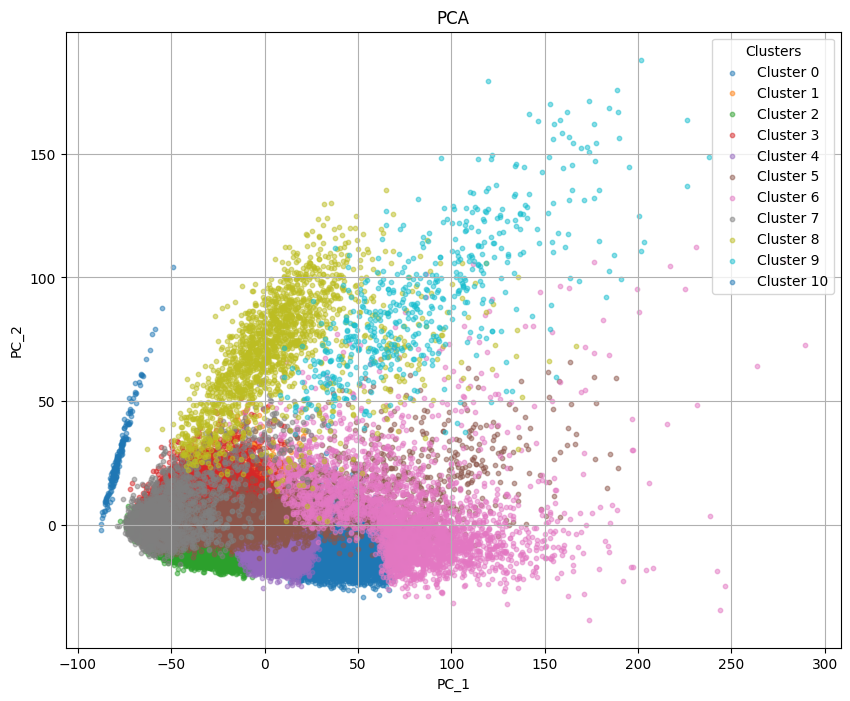

In [23]:
# Clustering visualization
reload(clustering)
clustering.visualize_clusters(pca_matrix, 'PCA', clustering1)

	Expression profile
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CD14+ Monocyte                32643 non-null  float64
 1   CD19+ B                       32643 non-null  float64
 2   CD34+                         32643 non-null  float64
 3   CD4+ T Helper2                32643 non-null  float64
 4   CD4+/CD25 T Reg               32643 non-null  float64
 5   CD4+/CD45RA+/CD25- Naive T    32643 non-null  float64
 6   CD4+/CD45RO+ Memory           32643 non-null  float64
 7   CD56+ NK                      32643 non-null  float64
 8   CD8+ Cytotoxic T              32643 non-null  float64
 9   CD8+/CD45RA+ Naive Cytotoxic  32643 non-null  float64
 10  Dendritic                     32643 non-null  float64
dtypes: float64(11)
memory usage: 3.0+ MB
None
celltype      CD14+ Monocyte  CD19+ B  CD34+  CD4+ T 

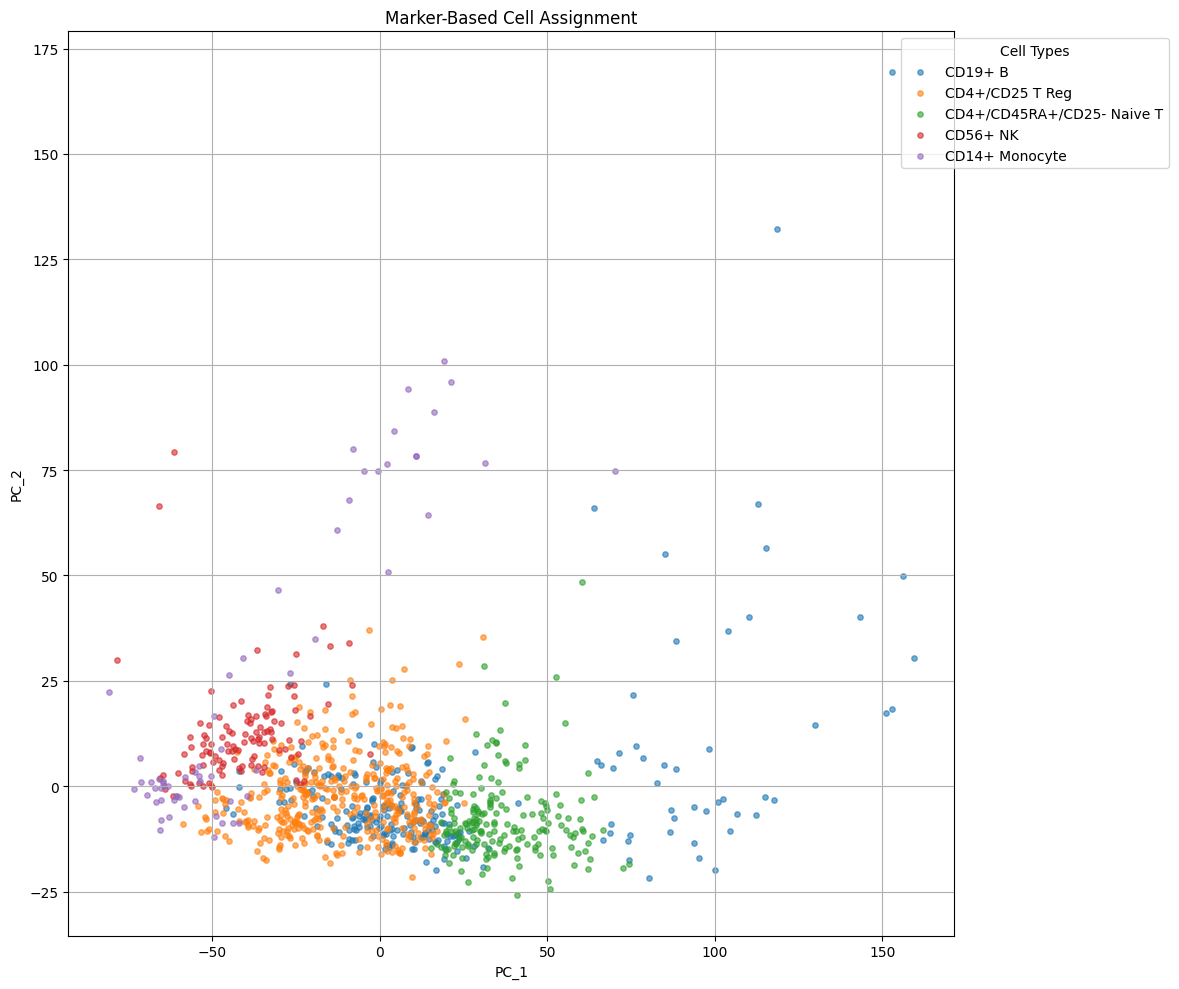

In [17]:
# Cell identification
reload(cell_identification)
gc.collect()
print("\tExpression profile")
expression_profile = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(expression_profile.info())
print(expression_profile.head())

print("\tMarker reference")
marker_genes = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(list(marker_genes.items())[:5])


In [ ]:
# Cell identification
reload(cell_identification)
print("\tReference based")
cell_id_1 = cell_identification.reference_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_1.head(10))

print("\tCorrelation based")
cell_id_2 = cell_identification.correlation_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_2.head(10))

print("\tMarker based")
cell_id_3 = cell_identification.marker_based_assignment(selected_matrix1, clustering1, marker_genes)
print(cell_id_3.head(10))

cell_identification.visualize_cells(pca_matrix, "Marker-Based Cell Assignment", cell_id_3)

In [18]:
# Evaluation metrics
reload(evaluation)
print("\tInternal evaluation")
internal_results = evaluation.internal_evaluation(pca_matrix, cell_id_1)
print(internal_results)

print("\tExternal evaluation")
external_results = evaluation.external_evaluation(cell_id_1, true_labels)
print(external_results)

	Internal evaluation
{'Silhouette_Score': 0.09343553372885167, 'ARI': 0.8299297353452566, 'NMI': 0.9315368757451317, 'V_measure': 0.9315368757451317}
	External evaluation
{'Accuracy': 0.413, 'Precision': 0.5207500526049246, 'Recall': 0.413, 'F1_score': 0.44865898791408926}


In [19]:
# Save results
import os
def save_results(pipeline_id, cell_identification_results, internal_metrics,
                 external_metrics, reduced_matrix, tissue):
    """
        Save the results of the pipeline including clustering, cell identification, and metrics.

        Parameters:
        -----------
        pipeline_id : str
            Unique identifier for the pipeline configuration.
        cell_identification_results : pd.DataFrame
            DataFrame containing 'barcode', 'cluster', and 'celltype' columns.
        internal_metrics : dict
            Dictionary containing internal evaluation metrics such as ARI, Silhouette, etc.
        external_metrics : dict
            Dictionary containing external evaluation metrics such as Accuracy, Precision, etc.
        reduced_matrix : pd.DataFrame
            Reduced dimensionality matrix (cells x dimensions).
        tissue : str
            Name of the tissue analyzed (e.g. PBMC).
        """
    # Create the results folder for the tissue if it doesn't exist
    tissue_results_path = f'results/{tissue}_results'
    os.makedirs(tissue_results_path, exist_ok=True)

    # Create the reduced matrix folder for the tissue if it doesn't exist
    tissue_reduced_matrix_path = f'{tissue_results_path}/{tissue}_reduced_matrix'
    os.makedirs(tissue_reduced_matrix_path, exist_ok=True)

    # Create a new row with the results of the pipeline
    result_row = {
        'pipeline_id': pipeline_id,  # Unique identifier for the pipeline
        'barcodes': ','.join(cell_identification_results['barcode'].tolist()),  # Convert the barcode list to a comma-separated string
        'clusters': ','.join(map(str, cell_identification_results['cluster'].tolist())),  # Convert clusters to string
        'cell_types': ','.join(cell_identification_results['celltype'].tolist()),  # Convert cell types to string
        'ARI': internal_metrics['ARI'],
        'Silhouette_Score': internal_metrics['Silhouette_Score'],
        'NMI': internal_metrics['NMI'],
        'V_measure': internal_metrics['V_measure'],
        'Accuracy': external_metrics['Accuracy'],
        'Precision': external_metrics['Precision'],
        'Recall': external_metrics['Recall'],
        'F1_score': external_metrics['F1_score']
    }

    # Save the results to a CSV file
    results_df = pd.DataFrame([result_row])

    # Check if the file already exists
    results_file_path = f'{tissue_results_path}/{tissue}_all_results.csv'
    if not os.path.exists(results_file_path):
        # If it doesn't exist, create it with headers
        results_df.to_csv(results_file_path, index=False, mode='w', header=True)
    else:
        # If it exists, append the new row without headers
        results_df.to_csv(results_file_path, index=False, mode='a', header=False)

    # Save the reduced dimensionality matrix in compressed format (CSV gzip) in the tissue-specific folder
    reduced_matrix_file_path = f'{tissue_reduced_matrix_path}/{pipeline_id}_matrix.csv.gz'
    reduced_matrix.to_csv(reduced_matrix_file_path, index=False, compression='gzip')

    print(f"Results for pipeline {pipeline_id} saved successfully.")

print("\tSave results")
pipeline_id = 'pipeline_1'
save_results(pipeline_id, cell_id_1, internal_results,
                 external_results, pca_matrix, 'PBMC')

	Save results
Results for pipeline pipeline_1 saved successfully.


In [34]:
# Execute step
def execute_step(step_name, methods_dict, method_name, data, extra_params=None):
    """
    Execute a specific step using the provided method.

    Parameters:
    -----------
    step_name : str
        The name of the pipeline step (e.g., 'data_cleaning', 'normalization', etc.).
    methods_dict : dict
        Dictionary containing methods for the current step.
    method_name : str
        The name of the method to be executed.
    data : pd.DataFrame
        The data to be processed by the method.
    extra_params : dict, optional
        Additional parameters required by the method (e.g., file paths, metadata).

    Returns:
    --------
    result : pd.DataFrame or pd.Series
        The result of the executed method.
    """
    method_entry = methods_dict[method_name]
    # Check if the dictionary contains a direct function or a sub-dictionary
    if callable(method_entry):  # Direct function
        method_func = method_entry
    else:  # Sub-dictionary with 'func' and 'params'
        method_func = method_entry['func']
        
    print(f"Running {step_name} - {method_name}")
    
    if extra_params:
        result = method_func(data, **extra_params) # If the function needs extra_params, call it with them
    else:
        result = method_func(data)  # Else, no extra_params is needed
    print(f"Execution of {step_name} - {method_name} done")
    return result

# Dictionary
data_cleaning_methods = {
    'FLEG': data_cleaning.filter_lowly_expressed_genes,
    'FHMC': data_cleaning.filter_high_mitochondrial_content,
    'FD': data_cleaning.filter_doublets_cxds,
    'CC': data_cleaning.combined_cleaning,
}

clustering_methods = {
    'GBC': {'func': clustering.graph_based_clustering_leiden, 'params': {'resolution': 1}},
    'DeBC': {'func': clustering.density_based_clustering, 'params': {'eps': 0.5, 'min_samples': 5}},
    'DiBC': {'func': clustering.distance_based_clustering, 'params': {'n_clusters': 10}},
    'HC': {'func': clustering.hierarchical_clustering, 'params': {'n_clusters': 5}},
    'DLC': {'func': clustering.deep_learning_clustering, 'params': {'n_clusters': 10, 'encoding_dim': 32}},
    'APC': {'func': clustering.affinity_propagation_clustering, 'params': None},
    'MMC': {'func': clustering.mixture_model_clustering, 'params': {'n_components': 10}},  # n_components is n_clusters
    'EC': {'func': clustering.ensemble_clustering, 'params': {'n_clusters': 11, 'eps': 0.5, 'min_samples': 5}},
}

for cluster_method, cluster_config in clustering_methods.items():
    result_step = execute_step('Clustering', clustering_methods, cluster_method, pca_matrix, cluster_config.get('params'))
    print(result_step.info())


Running Clustering - GBC
Execution of Clustering - GBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int32
dtypes: int32(1)
memory usage: 44.0+ KB
None
Running Clustering - DeBC
Execution of Clustering - DeBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int64
dtypes: int64(1)
memory usage: 47.9+ KB
None
Running Clustering - DiBC
Execution of Clustering - DiBC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCCCT-8
Series name: None
Non-Null Count  Dtype
--------------  -----
1000 non-null   int32
dtypes: int32(1)
memory usage: 44.0+ KB
None
Running Clustering - HC
Execution of Clustering - HC done
<class 'pandas.core.series.Series'>
Index: 1000 entries, CACTTATGTGTCCC-4 to ACGCCTTGTGCC

In [41]:
# Main pipeline
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import os
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation

def load_expression_data_from_mtx(path, barcodes_labeled=None, n_sample=None, random_state=None):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+"matrix.mtx").tocsc()

    # Load genes
    genes = pd.read_csv(path+"genes.tsv", header=None, sep='\t', names=['gene_id', 'gene_symbol'])

    # Load barcodes
    barcodes = pd.read_csv(path+"barcodes.tsv", header=None, sep='\t', names=['barcode'])

    # Filter by labeled barcodes if barcodes_labeled is provided
    if barcodes_labeled is not None:
        if 'barcode' not in barcodes_labeled.columns:
            raise ValueError("The provided barcodes_labeled DataFrame must contain a 'barcode' column.")
        # Find the intersection of barcodes
        labeled_barcodes = set(barcodes_labeled['barcode'])
        matching_indices = barcodes['barcode'].isin(labeled_barcodes)
        matrix = matrix[:, matching_indices]
        barcodes = barcodes[matching_indices]

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix


def save_results(results_path, pipeline_id, cell_identification_results, internal_metrics,
                 external_metrics, reduced_matrix, tissue):
    """
        Save the results of the pipeline including clustering, cell identification, and metrics.

        Parameters:
        -----------
        results_path : str
            Folder to save the results in.
        pipeline_id : str
            Unique identifier for the pipeline configuration.
        cell_identification_results : pd.DataFrame
            DataFrame containing 'barcode', 'cluster', and 'celltype' columns.
        internal_metrics : dict
            Dictionary containing internal evaluation metrics such as ARI, Silhouette, etc.
        external_metrics : dict
            Dictionary containing external evaluation metrics such as Accuracy, Precision, etc.
        reduced_matrix : pd.DataFrame
            Reduced dimensionality matrix (cells x dimensions).
        tissue : str
            Name of the tissue analyzed (e.g. PBMC).
        """
    # Create the results folder for the tissue if it doesn't exist
    tissue_results_path = f'{results_path}/{tissue}_results'
    os.makedirs(tissue_results_path, exist_ok=True)

    # Create the reduced matrix folder for the tissue if it doesn't exist
    tissue_reduced_matrix_path = f'{tissue_results_path}/{tissue}_reduced_matrix'
    os.makedirs(tissue_reduced_matrix_path, exist_ok=True)

    # Create a new row with the results of the pipeline
    result_row = {
        'pipeline_id': pipeline_id,  # Unique identifier for the pipeline
        'barcodes': ','.join(cell_identification_results['barcode'].tolist()),  # Convert the barcode list to a comma-separated string
        'clusters': ','.join(map(str, cell_identification_results['cluster'].tolist())),  # Convert clusters to string
        'cell_types': ','.join(cell_identification_results['celltype'].tolist()),  # Convert cell types to string
        'ARI': internal_metrics['ARI'],
        'Silhouette_Score': internal_metrics['Silhouette_Score'],
        'NMI': internal_metrics['NMI'],
        'V_measure': internal_metrics['V_measure'],
        'Accuracy': external_metrics['Accuracy'],
        'Precision': external_metrics['Precision'],
        'Recall': external_metrics['Recall'],
        'F1_score': external_metrics['F1_score']
    }

    # Save the results to a CSV file
    results_df = pd.DataFrame([result_row])

    # Check if the file already exists
    results_file_path = f'{tissue_results_path}/{tissue}_all_results.csv'
    if not os.path.exists(results_file_path):
        # If it doesn't exist, create it with headers
        results_df.to_csv(results_file_path, index=False, mode='w', header=True)
    else:
        # If it exists, append the new row without headers
        results_df.to_csv(results_file_path, index=False, mode='a', header=False)

    # Save the reduced dimensionality matrix in compressed format (CSV gzip) in the tissue-specific folder
    reduced_matrix_file_path = f'{tissue_reduced_matrix_path}/{pipeline_id}_matrix.csv.gz'
    reduced_matrix.to_csv(reduced_matrix_file_path, index=False, compression='gzip')

    print(f"Results for pipeline {pipeline_id} saved successfully.")


def generate_pipeline_id(methods_list):
    """
    Generate a unique pipeline ID based on the methods used.

    Parameters:
    -----------
    methods_list : list of str
        List of method names used in the pipeline.

    Returns:
    --------
    pipeline_id : str
        Unique pipeline identifier.
    """
    return "_".join(methods_list)


def execute_step(step_name, methods_dict, method_name, data, extra_params=None):
    """
    Execute a specific step using the provided method.

    Parameters:
    -----------
    step_name : str
        The name of the pipeline step (e.g., 'data_cleaning', 'normalization', etc.).
    methods_dict : dict
        Dictionary containing methods for the current step.
    method_name : str
        The name of the method to be executed.
    data : pd.DataFrame
        The data to be processed by the method.
    extra_params : dict, optional
        Additional parameters required by the method (e.g., file paths, metadata).

    Returns:
    --------
    result : pd.DataFrame or pd.Series
        The result of the executed method.
    """
    method_entry = methods_dict[method_name]
    # Check if the dictionary contains a direct function or a sub-dictionary
    if callable(method_entry):  # Direct function
        method_func = method_entry
    else:  # Sub-dictionary with 'func' and 'params'
        method_func = method_entry['func']
        
    print(f"Running {step_name} - {method_name}")
    
    if extra_params:
        result = method_func(data, **extra_params) # If the function needs extra_params, call it with them
    else:
        result = method_func(data)  # Else, no extra_params is needed
    print(f"Execution of {step_name} - {method_name} done")
    return result


# Dictionaries to execute methods in pipeline
data_cleaning_methods = {
    'FLEG': data_cleaning.filter_lowly_expressed_genes,
    'FHMC': data_cleaning.filter_high_mitochondrial_content,
    'FD': data_cleaning.filter_doublets_cxds,
    'CC': data_cleaning.combined_cleaning,
}

normalization_methods = {
    "CPM": normalization.normalize_cpm,
    "QR": normalization.normalize_quantile_regression,
    "NB": normalization.normalize_negative_binomial,
}

feature_selection_methods = {
    'SHVG': feature_selection.select_highly_variable_genes,
    'SGbV': feature_selection.select_genes_by_variance,
}

dim_reduction_methods = {
    'PCA': dim_reduction.apply_pca,
    'UMAP': dim_reduction.apply_umap,
    'TSNE': dim_reduction.apply_tsne,
}

# TO DO: adjust params
clustering_methods = {
    'GBC': {'func': clustering.graph_based_clustering_leiden, 'params': {'resolution': 1}},
    'DeBC': {'func': clustering.density_based_clustering, 'params': {'eps': 0.5, 'min_samples': 5}},
    'DiBC': {'func': clustering.distance_based_clustering, 'params': {'n_clusters': 11}},
    'HC': {'func': clustering.hierarchical_clustering, 'params': {'n_clusters': 11}},
    'DLC': {'func': clustering.deep_learning_clustering, 'params': {'n_clusters': 11, 'encoding_dim': 32}},
    'APC': {'func': clustering.affinity_propagation_clustering, 'params': None},
    'MMC': {'func': clustering.mixture_model_clustering, 'params': {'n_components': 11}},  # n_components is n_clusters
    'EC': {'func': clustering.ensemble_clustering, 'params': {'n_clusters': 11, 'eps': 0.5, 'min_samples': 5}},
}

cell_identification_methods = {
    'RBA': cell_identification.reference_based_assignment,
    'CBA': cell_identification.correlation_based_assignment,
    'MBA': cell_identification.marker_based_assignment,
}



### Main Pipeline ###
# Change params of dictionaries if needed
tissue = 'PBMC'
metadata_path = "./data/PBMC/PBMC_68k/hg19/68k_pbmc_barcodes_annotation.tsv"
results_path = "./results"

celltype_column = 'celltype'
true_labels = evaluation.load_true_labels(metadata_path, 'barcodes', celltype_column, "\t")

expression_matrix = load_expression_data_from_mtx("./data/PBMC/PBMC_68k/hg19/", barcodes_labeled=true_labels, n_sample=2000, random_state=6)

print(expression_matrix.info())

for cleaning_method in data_cleaning_methods.keys():
    cleaned_matrix = execute_step('data_cleaning', data_cleaning_methods, cleaning_method, expression_matrix)

    for norm_method in normalization_methods.keys():
        normalized_matrix = execute_step('normalization', normalization_methods, norm_method, cleaned_matrix)

        for fs_method in feature_selection_methods.keys():
            selected_matrix = execute_step('feature_selection', feature_selection_methods, fs_method, normalized_matrix)

            for dr_method in dim_reduction_methods.keys():
                # If tSNE, execute with predefined 2 dimensions
                if dr_method == 'TSNE':
                    reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, dr_method,
                                 selected_matrix)
                else:  # PCA or UMAP
                    # Execute PCA
                    pca_object, reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, 'PCA',
                                                            selected_matrix)
                    # If dr_method == PCA, continue, this step is already done
                    # else, if dr_method == UMAP, execute umap with the same number of dimensions as PCA
                    if dr_method == 'UMAP':
                        optimal_num_dimensions = reduced_matrix.shape[1]  # Get the number of components (columns)
                        reduced_matrix = execute_step('dim_reduction', dim_reduction_methods, dr_method,
                                                    selected_matrix, optimal_num_dimensions)

                for cluster_method, cluster_config in clustering_methods.items():
                    clustering_results = execute_step('clustering', clustering_methods, cluster_method, reduced_matrix,
                                                      cluster_config['params'])

                    for cell_id_method in cell_identification_methods.keys():
                        # For marker_based_assignment, marker reference is needed
                        if cell_id_method == 'MBA':
                            reference = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column=celltype_column, sep='\t')
                            key = 'marker_reference'
                        # For the other 2 methods, expression_profile is needed
                        else:
                            reference = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column=celltype_column, sep='\t')
                            key = 'expression_profile'

                        extra_params = {'cluster_results': clustering_results, key: reference}

                        cell_identification_results = execute_step(
                            'cell_identification', cell_identification_methods, cell_id_method, selected_matrix, extra_params
                        )

                        # Internal Evaluation
                        internal_metrics = evaluation.internal_evaluation(reduced_matrix, cell_identification_results)

                        # External Evaluation
                        external_metrics = evaluation.external_evaluation(cell_identification_results, true_labels)

                        # Generate unique pipeline identifier
                        pipeline_id = generate_pipeline_id([
                            cleaning_method, norm_method, fs_method, dr_method, cluster_method, cell_id_method
                        ])

                        # Save results
                        save_results(
                            results_path=results_path,
                            pipeline_id=pipeline_id,
                            cell_identification_results=cell_identification_results,
                            internal_metrics=internal_metrics,
                            external_metrics=external_metrics,
                            reduced_matrix=reduced_matrix,
                            tissue=tissue
                        )

print("Finish!")

<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Columns: 2000 entries, CACTTATGTGTCCC-4 to AAGCCATGGTCGTA-4
dtypes: Sparse[float64, 0](2000)
memory usage: 12.6+ MB
None
Running data_cleaning - FLEG
Execution of data_cleaning - FLEG done
Running normalization - CPM
Execution of normalization - CPM done
Running feature_selection - SHVG
Execution of feature_selection - SHVG done
Running dim_reduction - PCA
Execution of dim_reduction - PCA done
Running clustering - GBC
Execution of clustering - GBC done
Running cell_identification - RBA
Execution of cell_identification - RBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_RBA saved successfully.
Running cell_identification - CBA
Execution of cell_identification - CBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_CBA saved successfully.
Running cell_identification - MBA
Execution of cell_identification - MBA done
Results for pipeline FLEG_CPM_SHVG_PCA_GBC_MBA saved successfully.
Running clustering - DeBC
Ex

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [266]:
import os
import numpy as np
from scipy.sparse import coo_matrix, vstack
from scipy.io import mmread, mmwrite
import pandas as pd

# Base directory and folder names
base_dir = "./data/Tumor/"
folders = ["CID3586", "CID3838", "CID3921", "CID3941", "CID3946", "CID3948",
           "CID3963", "CID4040", "CID4066", "CID4465", "CID4495", "CID44041",
           "CID4067", "CID4398", "CID4461", "CID4463", "CID4513", "CID4515",
           "CID4523", "CID4535", "CID4471"]

# Initialize variables to keep track of combined data
gene_index_map = {}  # Map from gene to row index
all_data = []  # List of sparse matrices
all_cells = set()  # To collect all unique barcodes
all_genes = set()
current_row_offset = 0

# First pass: Collect all unique cell barcodes and genes
for folder in folders:
    cells_file = os.path.join(base_dir, folder, "count_matrix_barcodes.tsv")
    cells = pd.read_csv(cells_file, header=None, sep="\t", names=["cell_id"])["cell_id"].tolist()
    all_cells.update(cells)
    genes_file = os.path.join(base_dir, folder, "count_matrix_genes.tsv")
    genes = pd.read_csv(genes_file, header=None, sep="\t", names=["gene_id"])["gene_id"].tolist()
    all_genes.update(genes)

# Create a mapping from barcode and gene to column index
all_cells = sorted(all_cells)  # Ensure consistent order
cell_index_map = {cell: idx for idx, cell in enumerate(all_cells)}
total_cells = len(all_cells)

all_genes = sorted(all_genes) 
gene_index_map = {gene: idx for idx, gene in enumerate(all_genes)}
total_genes = len(all_genes)

print(f"Total unique cells: {total_cells}")
print(f"Total unique genes: {total_genes}")

# Iterate through folders and process matrices
for i, folder in enumerate(folders):
    folder_path = os.path.join(base_dir, folder)
    mtx_file = os.path.join(folder_path, "count_matrix_sparse.mtx")

    print(f"Processing folder {i + 1}/{len(folders)}: {folder}")

    # Read sparse matrix from the file
    matrix = mmread(mtx_file).tocoo()
    print("matrix read")
    
    # Load gene and cell information (assuming rows = genes, cols = cells)
    genes_file = os.path.join(folder_path, "count_matrix_genes.tsv")  # File containing gene names
    cells_file = os.path.join(folder_path, "count_matrix_barcodes.tsv")  # File containing cell barcodes

    genes = pd.read_csv(genes_file, header=None, sep="\t", names=["gene_id"])["gene_id"].tolist()
    cells = pd.read_csv(cells_file, header=None, sep="\t", names=["cell_id"])["cell_id"].tolist()

    # Map genes to a global index and adjust row indices of the matrix
    new_rows = []
    for row_index in matrix.row:
        gene = genes[row_index]  # Get the gene name corresponding to the row index
        if gene not in gene_index_map:
            gene_index_map[gene] = current_row_offset
            current_row_offset += 1
        new_rows.append(gene_index_map[gene])

   # Map cells to a global index and adjust column indices of the matrix
    new_cols = [cell_index_map[cells[col]] for col in matrix.col]

    # Convert new_rows and new_cols to NumPy arrays
    new_rows = np.array(new_rows)
    new_cols = np.array(new_cols)

    # Create a new sparse matrix with aligned row and column indices
    updated_matrix = coo_matrix((matrix.data, (new_rows, new_cols)), 
                                shape=(total_genes, total_cells))

    # Append updated matrix to the list
    all_data.append(updated_matrix)

    print(f"Finished processing folder {folder}. Current total genes: {current_row_offset}")

# Combine all matrices vertically
print("Combining all matrices into a single matrix...")
combined_matrix = sum(all_data)  # Sum overlapping rows by adding matrices
print(f"Combined matrix dimensions: {combined_matrix.shape[0]} rows, {combined_matrix.shape[1]} columns")

# Save the final matrix
output_file = os.path.join(base_dir, "all_matrix.mtx")
mmwrite(output_file, combined_matrix)

# Save the gene and cell lists
gene_list = [gene for gene, _ in sorted(gene_index_map.items(), key=lambda x: x[1])]
pd.DataFrame(["genes"] + gene_list).to_csv(os.path.join(base_dir, "all_genes.tsv"), header=False, index=False, sep="\t")
pd.DataFrame(["barcodes"] + all_cells).to_csv(os.path.join(base_dir, "all_barcodes.tsv"), header=False, index=False, sep="\t")

print("All matrices have been successfully combined and saved.")

Total unique cells: 72410
Total unique genes: 29733
Processing folder 1/21: CID3586
matrix read
Finished processing folder CID3586. Current total genes: 0
Processing folder 2/21: CID3838
matrix read
Finished processing folder CID3838. Current total genes: 0
Processing folder 3/21: CID3921
matrix read
Finished processing folder CID3921. Current total genes: 0
Processing folder 4/21: CID3941
matrix read
Finished processing folder CID3941. Current total genes: 0
Processing folder 5/21: CID3946
matrix read
Finished processing folder CID3946. Current total genes: 0
Processing folder 6/21: CID3948
matrix read
Finished processing folder CID3948. Current total genes: 0
Processing folder 7/21: CID3963
matrix read
Finished processing folder CID3963. Current total genes: 0
Processing folder 8/21: CID4040
matrix read
Finished processing folder CID4040. Current total genes: 0
Processing folder 9/21: CID4066
matrix read
Finished processing folder CID4066. Current total genes: 0
Processing folder 10/

In [273]:
def load_expression_data_from_mtx(path, matrix_name, genes_name, barcodes_name):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+matrix_name)
    print("Matrix read")

    # Load genes
    genes = pd.read_csv(path+genes_name, header=0, sep='\t', names=['genes'])
    print("Genes read")

    # Load barcodes
    barcodes = pd.read_csv(path+barcodes_name, header=0, sep='\t', names=['barcodes'])
    print("Barcodes read")

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['genes']
    expression_matrix.columns = barcodes['barcodes']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix
    
expression_matrix_tumor = load_expression_data_from_mtx("./data/Tumor/",
                                                        matrix_name = "all_matrix.mtx",
                                                        genes_name = "all_genes.tsv",
                                                        barcodes_name= "all_barcodes.tsv")
print(expression_matrix_tumor.info())

duplicated_genes = expression_matrix.index[expression_matrix.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")
else:
     print("No hay genes duplicados")


Matrix read
Genes read
Barcodes read
<class 'pandas.core.frame.DataFrame'>
Index: 29733 entries, A1BG to bP-2189O9.3
Columns: 72410 entries, CID3586_AAACCTGAGAGTAATC to CID4535_TTTGTCATCTTTAGTC
dtypes: Sparse[int64, 0](72410)
memory usage: 1.4+ GB
None
barcodes  CID3586_AAACCTGAGAGTAATC  CID3586_AAACCTGAGGCTCAGA  \
genes                                                          
A1BG                             1                         0   
A1BG-AS1                         0                         0   
A1CF                             0                         0   
A2M                              0                         0   
A2M-AS1                          0                         0   

barcodes  CID3586_AAACCTGAGGTGACCA  CID3586_AAACCTGAGTCTCCTC  \
genes                                                          
A1BG                             0                         0   
A1BG-AS1                         0                         0   
A1CF                             0        

In [283]:
metadata_path_tumor = "./data/Tumor/metadata_all.csv"
true_labels_tumor = evaluation.load_true_labels(metadata_path_tumor, 'Unnamed: 0', 'celltype_major', ',')
print(true_labels_tumor.info())
print(true_labels_tumor.head())
print(true_labels_tumor['true_label'].unique())
print(len(true_labels_tumor['true_label'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72410 entries, 0 to 72409
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   barcode     72410 non-null  object
 1   true_label  72410 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None
                    barcode   true_label
0  CID3586_AAGACCTCAGCATGAG  Endothelial
1  CID3586_AAGGTTCGTAGTACCT  Endothelial
2  CID3586_ACCAGTAGTTGTGGCC  Endothelial
3  CID3586_ACCCACTAGATGTCGG  Endothelial
4  CID3586_ACTGATGGTCAACTGT  Endothelial
['Endothelial' 'CAFs' 'PVL' 'B-cells' 'T-cells' 'Myeloid'
 'Normal Epithelial' 'Plasmablasts' 'Cancer Epithelial']
9


In [ ]:
import pandas as pd
import scipy.sparse
import joblib

# Ruta al archivo CSV
csv_path = "../data/Neuronal/M1/matrix.csv"

def read_and_process_csv_in_chunks(csv_path, chunk_size=10000, output_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    """
    Read a large CSV file in chunks, transpose, convert to sparse, and concatenate.

    Parameters:
    - csv_path: str, path to the CSV file.
    - chunk_size: int, number of rows to read in each chunk.

    Returns:
    - sparse_expression_matrix: Sparse DataFrame containing the full gene expression data.
    """
    # Initialize a list to store processed chunks
    processed_chunks = []
    genes = None
    barcodes = []
    print(f"Empezamos", flush=True)
    
    # Read the CSV in chunks
    for chunk in pd.read_csv(csv_path, sep=',', chunksize=chunk_size,  header=0, index_col=0):
        print(f"Processing chunk rows {chunk.index[0]} to {chunk.index[-1]}...", flush=True)

        # Keep genes
        if genes is None:
            genes = chunk.columns.tolist()
        
        # Keep barcodes
        barcodes.extend(chunk.index.tolist())
        
        # Transpose the chunk so rows are genes and columns are barcodes
        chunk = chunk.T
        
        # Convert to Sparse DataFrame
        sparse_chunk = scipy.sparse.csr_matrix(chunk)
        
        # Add the processed chunk to the list
        processed_chunks.append(sparse_chunk)
        
        # Free memory from the current chunk
        del chunk  # Optional, to ensure the original chunk memory is freed
        
    # Concatenate all processed chunks into a single Sparse DataFrame
    full_sparse_matrix = scipy.sparse.vstack(processed_chunks)
    sparse_expression_matrix = pd.DataFrame.sparse.from_spmatrix(
        full_sparse_matrix,
        index=genes,
        columns=barcodes
    )

    joblib.dump(sparse_expression_matrix, output_file)
    
    # Return the complete Sparse DataFrame
    return sparse_expression_matrix

def load_sparse_dataframe(input_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    return joblib.load(input_file)


# Read and process the CSV in chunks
sparse_matrix = read_and_process_csv_in_chunks(csv_path)

sparse_dataframe = load_sparse_dataframe('../data/Neuronal/M1/sparse_dataframe.joblib')

# Show column names (First 10)
print("Column Names Matrix (First 10):", sparse_matrix.columns[:10])

# Show head of the Sparse Expression Matrix
print("\nHead of the Sparse Expression Matrix:")
print(sparse_matrix.head())

# Show data types of the Sparse Expression Matrix
print("\nData Types of the Sparse Expression Matrix:")
print(sparse_matrix.dtypes)

# Show shape of the Sparse Expression Matrix
print("\nShape of the Sparse Expression Matrix:", sparse_matrix.shape)

# Mostrar información
print("Dimensiones de la matriz:", sparse_dataframe.shape)
print("\nPrimeros 5 genes:", sparse_dataframe.index[:5])
print("\nPrimeros 5 barcodes:", sparse_dataframe.columns[:5])
print("\nMuestra de la matriz:")
print(sparse_dataframe.iloc[:5, :5])

Empezamos
Processing chunk rows AAACCCAAGGATTTCC-LKTX_190129_01_A01 to ATCGCCTTCACTGGGC-LKTX_190129_01_C01...
Processing chunk rows ATCGCCTTCGAGAAAT-LKTX_190129_01_C01 to CATCCACAGGCCGCTT-LKTX_190129_01_E01...
Processing chunk rows CATCCACCAAATGCGG-LKTX_190129_01_E01 to TTTCGATCACCATTCC-LKTX_190129_01_F01...
Processing chunk rows TTTCGATCATACATCG-LKTX_190129_01_F01 to TCGCTTGGTTTACGTG-LKTX_190130_01_A01...
